In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import random
from sklearn.preprocessing import LabelEncoder
import os

In [3]:

pos_df = pd.read_csv('positive10k.txt', sep='\t', header=None) 
neg_df = pd.read_csv('negative10k.txt', sep='\t', header=None)
cmt_msg_df = pd.read_csv('commit-messages.txt', sep='\t', header=None) 
question_df = pd.read_csv('questions.txt', sep='\t', header=None) 

pos_df.shape, neg_df.shape, cmt_msg_df.shape, question_df.shape

((9935, 1), (9719, 1), (14195, 1), (5411, 1))

In [4]:
pos_df[1]='positive'
neg_df[1]='negative'
cmt_msg_df[1]='enhancement'
question_df[1]='question'

In [5]:
df = pd.DataFrame(pos_df)
df = df.append(neg_df)
df = df.append(cmt_msg_df[:10000])
df = df.append(question_df)
df.shape

(35065, 2)

In [6]:
df[1].value_counts(), df[1].value_counts().sum(),df[1].value_counts()["enhancement"]

(enhancement    10000
 positive        9935
 negative        9719
 question        5411
 Name: 1, dtype: int64,
 35065,
 10000)

In [7]:
weight_for_enhancement = (1 / df[1].value_counts()["enhancement"])*(35065)/4.0
weight_for_positive = (1 / df[1].value_counts()["positive"])*(35065)/4.0
weight_for_negative = (1 / df[1].value_counts()["negative"])*(35065)/4.0
weight_for_question = (1 / df[1].value_counts()["question"])*(35065)/4.0
weight_for_enhancement, weight_for_positive,weight_for_negative, weight_for_question

(0.876625, 0.882360342224459, 0.9019703673217409, 1.6200794677508779)

In [8]:
df = df.sample(frac = 1, random_state = 42)
df

,0,1
6070,Love it I am learning a brand new language Sp...,positive
3166,who drives the number 95 car in nascar,question
665,where can you find dna in the body,question
1483,LOVE you,positive
4219,Cute and educated game for kids This game is e...,positive
...,...,...
6915,Only two free puzzles out of 6 .. bs,negative
6265,Excellent Apps Very nice easy to use....... T...,positive
1349,0 stars Would give it 5 stars if you would fix...,negative
860,Good game I can play it but i wish it didn't h...,positive


<AxesSubplot:>

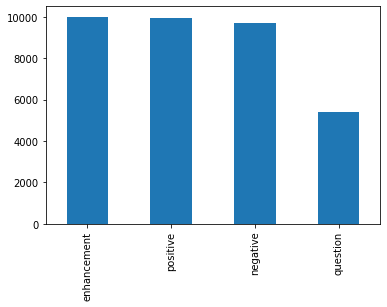

In [9]:
df[1].value_counts().plot(kind='bar')


In [10]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df[0].to_numpy(),
                                                                            df[1].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(28052, 28052, 7013, 7013)

In [11]:
max_vocab_length = 10000
avg_sentence_length = int(np.mean([len(s.split()) for s in train_sentences]))
avg_sentence_length

14

In [12]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                     standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    output_sequence_length=avg_sentence_length)
text_vectorizer.adapt(train_sentences)

2022-02-20 23:16:41.959947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 23:16:42.067179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 23:16:42.067734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-20 23:16:42.069544: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [13]:
# integer encode
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(val_labels)
y_train[0],y_test[0] , label_encoder.classes_

(0,
 3,
 array(['enhancement', 'negative', 'positive', 'question'], dtype=object))

In [14]:
class_weight = {0: weight_for_enhancement, 1: weight_for_negative, 2: weight_for_positive, 3: weight_for_question}

In [15]:
train_sentences[0], val_sentences[0], y_train[0], y_test[0]

('Update `StandardConfigDataLocationResolver` to deal with patterns when',
 'when was the minimum wage established in the united states ',
 0,
 3)

In [16]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = layers.Embedding(max_vocab_length, 128)(x) # create an embedding of the numerized numbers
#x = layers.GRU(128)(x) # create a GRU layer with 128 units
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.9, recurrent_dropout=0.9))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(32, dropout=0.7, recurrent_dropout=0.9))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [17]:
with tf.device('/cpu:0'):
    model_history = model.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                                y_train,
                                epochs=5,
                                verbose=1,
                                validation_data=(val_sentences, y_test),
                                class_weight=class_weight)

Epoch 1/5
877/877 [==============================] - 104s 109ms/step - loss: 0.5467 - accuracy: 0.7545 - val_loss: 0.2643 - val_accuracy: 0.8953
Epoch 2/5
877/877 [==============================] - 96s 109ms/step - loss: 0.2509 - accuracy: 0.8978 - val_loss: 0.2079 - val_accuracy: 0.9229
Epoch 3/5
877/877 [==============================] - 96s 110ms/step - loss: 0.2000 - accuracy: 0.9180 - val_loss: 0.2064 - val_accuracy: 0.9247
Epoch 4/5
877/877 [==============================] - 95s 108ms/step - loss: 0.1749 - accuracy: 0.9297 - val_loss: 0.2151 - val_accuracy: 0.9251
Epoch 5/5
877/877 [==============================] - 95s 109ms/step - loss: 0.1595 - accuracy: 0.9373 - val_loss: 0.2090 - val_accuracy: 0.9259


In [22]:
prediction=model.predict(["Where is the adoption process"])
label_encoder.inverse_transform([np.argmax(prediction)])

array(['question'], dtype=object)